In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.1)


# Importing essential libraries

In [0]:
import pandas as pd
import numpy as np
import gensim

import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
import gensim.models.nmf
import pickle

# Importing the processed dataset

In [0]:
DATA_PATH = '/content/drive/My Drive/ALDA-Submission/Data/processed_data.csv'

In [0]:
dataset = pd.read_csv(DATA_PATH, index_col = 0)

## Import libraries for data cleaning

In [89]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Defining a cleanup function

In [0]:
def clean(document):
  
  doc1 = document.rstrip()
  doc2 = re.sub(r'[^a-zA-Z]', ' ', doc1)
  doc3 = " ".join([i for i in doc2.lower().split() if i not in stop])
  doc4 = ''.join(ch for ch in doc3 if ch not in exclude)
  doc5 = re.sub(r"\b[a-zA-Z]\b", "", doc4)
  doc6 = " ".join(lemma.lemmatize(word) for word in doc5.split())

  return doc6

In [0]:
#document = dataset['message_content'].apply(clean)

In [0]:
document = pd.read_csv('/content/drive/My Drive/ALDA-Submission/Data/cleaned_data.csv', index_col = 0)

# Non negative Matrix Factorization Implementation

## Create a document-word corpus and dictionary


In [0]:
texts = document['new_msg'].dropna()

texts = [d.split() for d in texts]

common_dictionary = gensim.corpora.dictionary.Dictionary(texts)

common_corpus = [common_dictionary.doc2bow(text) for text in texts]

## Hyperparemeters

In [0]:
topic_values = [i for i in range(1, 32, 2)]

In [94]:
topic_values

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

## Hyperparameter Tuning

### Hyper parameter Set 1

In [0]:
coherence_values_set1 = []

for i in topic_values:

  nmf = gensim.models.nmf.Nmf(common_corpus, num_topics = i,
                            chunksize = 5000,
                            w_max_iter = 11,
                            h_max_iter = 10,
                            id2word = common_dictionary,
                            random_state = 100)
  
  nmf.save("/content/drive/My Drive/ALDA-Submission/Models/model_Set_1_"+ str(i) +".pkl")

  print("Model {} done".format(i))
  
  cm = CoherenceModel(model = nmf,
                      corpus = common_corpus,
                      coherence = 'c_v',
                      dictionary = common_dictionary,
                      texts = texts)

  coherence = cm.get_coherence()

  coherence_values_set1.append(coherence)

  print("Coherence Value of model : {} is {} ".format(i, coherence))

### Hyper parameter Set 2

In [0]:
coherence_values_set2 = []

for i in topic_values:

  nmf = gensim.models.nmf.Nmf(common_corpus,
                              num_topics = i,
                              chunksize = 5000,
                              w_max_iter = 10,
                              h_max_iter = 10,
                              id2word = common_dictionary,
                              random_state = 100,
                              w_stop_condition = 0.001,
                              h_stop_condition = 0.01)
  
  nmf.save("/content/drive/My Drive/ALDA-Submission/Models/model_Set_2_"+ str(i) +".pkl")

  print("Model {} done".format(i))
  
  cm = CoherenceModel(model = nmf,
                      corpus = common_corpus,
                      coherence = 'c_v',
                      dictionary = common_dictionary,
                      texts = texts)

  coherence = cm.get_coherence()

  coherence_values_set2.append(coherence)

  print("Coherence Value of model : {} is {} ".format(i, coherence))

## Plotting the results of hyper parameter tuning

### Hyper parameter Set 1

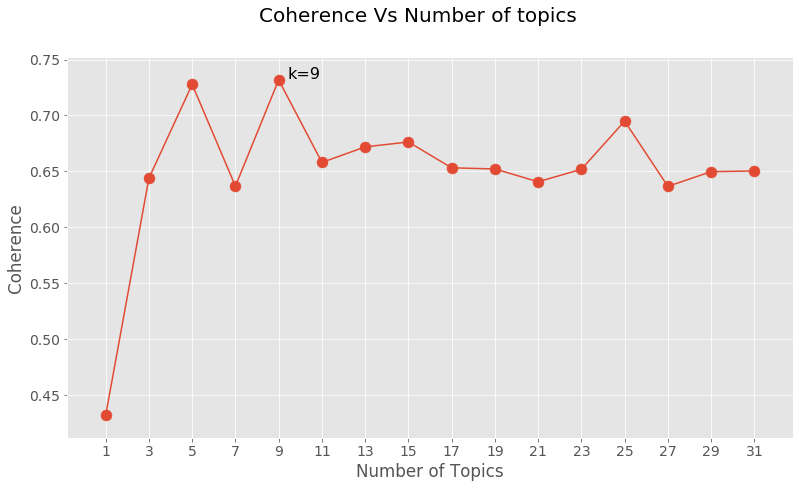

In [0]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

k_values = range(1, 32, 2)
coherences = coherence_values_set1

fig = plt.figure(figsize=(13,7))
fig.suptitle('Coherence Vs Number of topics', fontsize=20)
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")

plt.scatter( k_values, coherences, s = 120)

ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.savefig('/content/drive/My Drive/ALDA-Submission/Plots/NMF-HP1.png')
plt.show()

### Hyper parameter Set 2

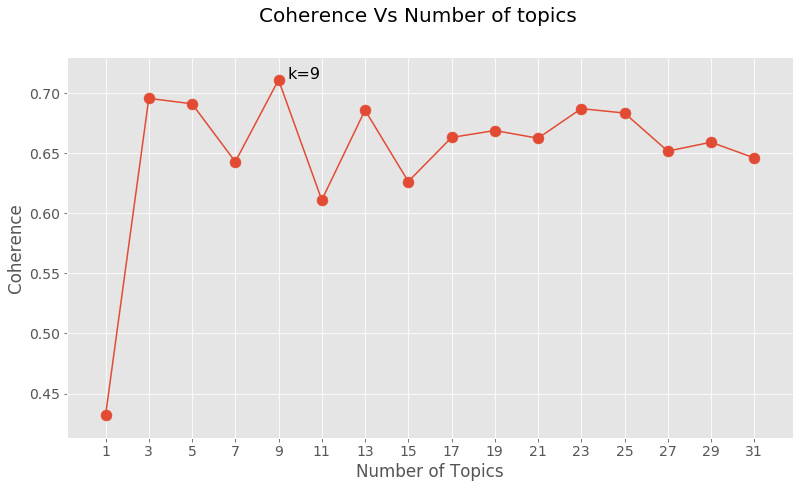

In [0]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

k_values = range(1, 32, 2)
coherences = coherence_values_set2

fig = plt.figure(figsize=(13,7))
fig.suptitle('Coherence Vs Number of topics', fontsize=20)
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")

plt.scatter( k_values, coherences, s = 120)

ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.savefig('/content/drive/My Drive/ALDA-Submission/Plots/NMF-HP2.png')
plt.show()

# Discussion of results

Here we get the maximum coherence score of 0.73 for the Hyper parameter set 1 and the optimal number of topics as 9. 


We load this model and continue with the exploration of results

In [0]:
nmf = gensim.models.nmf.Nmf.load("/content/drive/My Drive/ALDA-Submission/Models/model_Set_1_9.pkl")

## Get the most significant topics

In [96]:
nmf.print_topics()

[(0,
  '0.099*"omni" + 0.062*"pm" + 0.044*"forney" + 0.044*"djohn" + 0.042*"dect" + 0.042*"dhou" + 0.028*"ou" + 0.028*"cn" + 0.019*"omnioriginaldatetime" + 0.019*"busy"'),
 (1,
  '0.056*"enron" + 0.014*"company" + 0.010*"said" + 0.008*"ect" + 0.006*"stock" + 0.005*"corp" + 0.005*"share" + 0.005*"energy" + 0.004*"financial" + 0.004*"dynegy"'),
 (2,
  '0.019*"said" + 0.018*"power" + 0.017*"state" + 0.016*"california" + 0.016*"energy" + 0.010*"price" + 0.009*"electricity" + 0.008*"davis" + 0.007*"utility" + 0.006*"plant"'),
 (3,
  '0.018*"company" + 0.015*"million" + 0.012*"said" + 0.011*"venture" + 0.010*"round" + 0.010*"service" + 0.009*"com" + 0.009*"firm" + 0.009*"new" + 0.009*"www"'),
 (4,
  '0.109*"td" + 0.087*"font" + 0.032*"size" + 0.030*"align" + 0.029*"br" + 0.026*"tr" + 0.024*"class" + 0.019*"nbsp" + 0.018*"right" + 0.016*"href"'),
 (5,
  '0.123*"com" + 0.046*"enron" + 0.032*"ect" + 0.018*"hou" + 0.011*"ee" + 0.010*"mail" + 0.006*"gov" + 0.005*"mailto" + 0.004*"aol" + 0.004*"u"

## Get top 20 terms from every topic

In [0]:
columns = ["Topic - " + str(i) for i in range(9)]

In [0]:
top20 = []

for i in range(0, 9):
  t = []
  topics = nmf.get_topic_terms(i, topn = 20)
  for j in range(len(topics)):
    t.append(common_dictionary[topics[j][0]])
  top20.append(t)

In [0]:
df = pd.DataFrame(top20, index=columns).transpose()

In [43]:
df

,Topic - 0,Topic - 1,Topic - 2,Topic - 3,Topic - 4,Topic - 5,Topic - 6,Topic - 7,Topic - 8
0,omni,enron,said,company,td,com,com,omni,power
1,pm,company,power,million,font,enron,www,pm,company
2,forney,said,state,said,size,ect,image,cn,said
3,djohn,ect,california,venture,align,hou,nbsp,ou,state
4,dect,stock,energy,round,br,ee,gif,ect,market
5,dhou,corp,price,service,tr,mail,tr,enron,gas
6,ou,share,electricity,com,class,gov,width,hou,utility
7,cn,energy,davis,firm,nbsp,mailto,br,omniorgtable,energy
8,omnioriginaldatetime,financial,utility,new,right,aol,id,updatedby,year
9,busy,dynegy,plant,www,href,u,rigzone,omnistartdatetime,would


## Get the dominant topic

Here every email is associated with a certain probability that its belongs to a particular topic. We get the topic with the maximum probbility associated with every email. The topic with the maximum probability is the dominant topic

#### Extract the dominant topics for every email

In [0]:
lda_corpus = [max(prob, key = lambda y:y[1]) for prob in nmf[common_corpus]]

#### Save the object as the extraction takes a long time

In [0]:
file1 = open('/content/drive/My Drive/ALDA-Submission/Topics.pkl', 'wb')

pickle.dump(lda_corpus, file1)

In [0]:
file1 = open('/content/drive/My Drive/ALDA-Submission/Topics.pkl', 'rb')

lda_corpus = pickle.load(file1)

## Label the dataset with the appropriate topic

In [0]:
l = [lda_corpus[i][0] for i in range(len(lda_corpus))]

In [0]:
df = document[document['new_msg'].notnull()]

In [125]:
df['dominant_topic'] = l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Plotting the distribution of emails for the year 2000 for every topic




In [126]:
df[["day", "date", "month", "year" ,"time", "hours", "timezone"]] = df["Date"].str.split(" ", expand=True)
x = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df['month'] = pd.Categorical(df['month'], categories=x, ordered=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


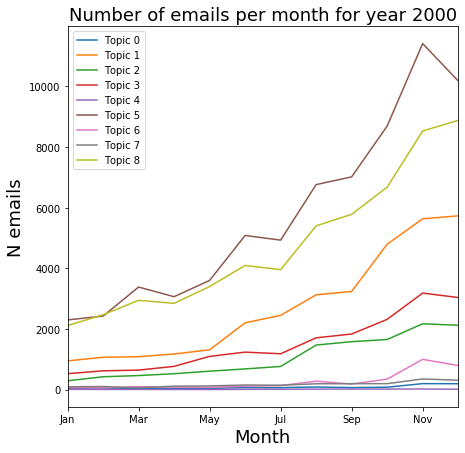

In [142]:
for topic in range(9):  
  df_topic = df.loc[df['dominant_topic'] ==topic]
  sub_df_topic = df_topic.loc[df_topic['year'].isin(['2000'])]
  ax = sub_df_topic.groupby(['month'])['day'].count().plot(figsize=(7,7))
  ax.legend(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8'])
  ax.set_xlabel('Month', fontsize=18)
  ax.set_ylabel('N emails', fontsize=18)  
  ax.set_title("Number of emails per month for year 2000", fontsize = 18)   

# Plotting the distribution of emails for the year 2001 for every topic




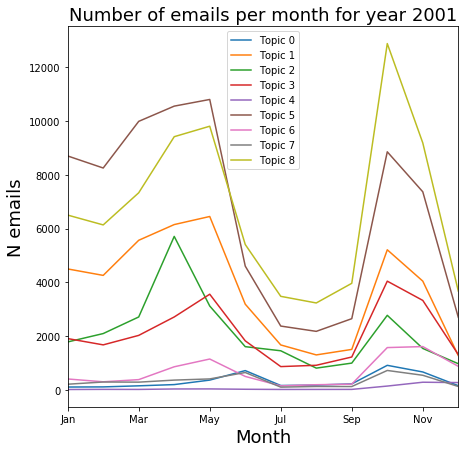

In [143]:
for topic in range(9):  
  df_topic = df.loc[df['dominant_topic'] ==topic]
  sub_df_topic = df_topic.loc[df_topic['year'].isin(['2001'])]
  ax = sub_df_topic.groupby(['month'])['day'].count().plot(figsize=(7,7))
  ax.legend(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8'])
  ax.set_xlabel('Month', fontsize=18)
  ax.set_ylabel('N emails', fontsize=18)   
  ax.set_title("Number of emails per month for year 2001", fontsize = 18)   